In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
import time
warnings.filterwarnings('ignore')

# imports for Part 2

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV

# !pip install contractions # install contractions package

# import contractions


Text(0.5, 1.0, 'logistic function')

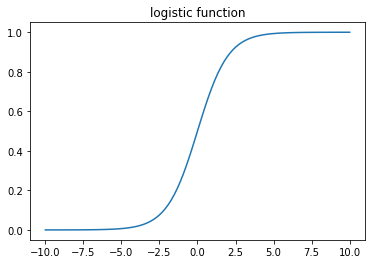

In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function
z = np.linspace(-10,10,100)
plt.plot(z, logistic(z))
plt.title('logistic function')

## Cost function
To fit our model $f_w$ to the data $\mathcal{D} = \{x^{(1)}, \ldots, x^{(N)}\}$, we maximize the **logarithm of the conditional likelihood**:

$$
\ell(w; \mathcal{D}) = \sum_n \log \mathrm{Bernoulli}(y^{(n)} | \sigma({x^{(n)}}^\top w)) = \sum_n y^{(n)} \log \sigma({x^{(n)}}^\top w)) + (1-y^{(n)}) \log (1-\sigma({x^{(n)}}^\top w)))
$$

by substituting the definition of logistic function in the equation above, and minimizing the **negative** of the log-likelihood, which is called the **cost function**,
we get

$$
J(w) = \sum_n y^{(n)} \log(1+e^{-x w^\top}) + (1-y^{(n)}) \log(1+e^{x w^\top})
$$

In practice we use mean rather than sum over data points.

In [ ]:
def cost_fn(x, y, w):
    N, D = x.shape                                                       
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J

## Minimizing the cost using gradient descent
To minimize the cost we use gradient descent: start from some initial assignment to the parameters $w$, and at each iteration take a small step in the opposite direction of the *gradient*. The gradient of the cost function above is given by:

$$
\frac{\partial}{\partial w_d} J(w) =\sum_n - y^{(n)} x^{(n)}_d \frac{e^{-w^\top x^{(n)}}}{1 + e^{-w^\top x^{(n)}}} +x^{(n)}_d (1- y^{(n)}) \frac{e^{w^\top x^{(n)}}}{1 + e^{w^\top x^{(n)}}} = \sum_n - x^{(n)}_d y^{(n)} (1-\hat{y}^{(n)})+ x^{(n)}_d (1- y^{(n)}) \hat{y}^{(n)} = x^{(n)}_d (\hat{y}^{(n)} - y^{(n)}) 
$$
Since in practice we divide the cost by $N$, we have to the same for the gradient; see the implementation below.

In [ ]:
def gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))    # predictions  size N
    grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
    return grad                         # size D

## Logistic regression class
Now we are ready to implement the logistic regression class with the usual `fit` and `predict` methods. Here, the `fit` method implements gradient descent.

In [ ]:
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

LogisticRegression.gradient = gradient             #initialize the gradient method of the LogisticRegression class with gradient function

# Part 1. Optimization when including 'Insulin' feature

In [ ]:
# ignore tf–idf transformation

n_min = [0, 0.05, 0.1]
n_max = [0.6, 0.70]
ngrams = [(1, 1), (1, 2), (1, 3)]

accuracies = []

for min in n_min:
  for max in n_max:
    for item in ngrams:
      # build dictionary of features and transform documents to feature vectors using CountVectorizer from sklearn
      count_vect = CountVectorizer(strip_accents='unicode', ngram_range=item, max_df=max, min_df=min, max_features=None)
      X_train_counts = count_vect.fit_transform(df_train['text'])

      # train logistic regression model

      clf = LogisticRegression().fit(X_train_counts, df_train['label'])

      # extract features from test dataset to calculate predictions
      X_test_counts = count_vect.transform(df_test['text'])

      # make predictions
      predictions = clf.predict(X_test_counts)
      accuracy = np.mean(predictions == df_test['label'])

      print('Parameters min, max, ngrams: {}, {}, {}'.format(min, max, item))
      print('Accuracy: ' + str(accuracy))

# best accuracy acheived: 
# Parameters min, max, ngrams: 0, 0.7, (1, 3)
# Accuracy: 0.769

Parameters min, max, ngrams: 0, 0.6, (1, 1)
Accuracy: 0.7166666666666667
Parameters min, max, ngrams: 0, 0.6, (1, 2)
Accuracy: 0.758
Parameters min, max, ngrams: 0, 0.6, (1, 3)
Accuracy: 0.7646666666666667
Parameters min, max, ngrams: 0, 0.7, (1, 1)
Accuracy: 0.7186666666666667
Parameters min, max, ngrams: 0, 0.7, (1, 2)
Accuracy: 0.7626666666666667
Parameters min, max, ngrams: 0, 0.7, (1, 3)
Accuracy: 0.769
Parameters min, max, ngrams: 0.05, 0.6, (1, 1)
Accuracy: 0.6833333333333333
Parameters min, max, ngrams: 0.05, 0.6, (1, 2)
Accuracy: 0.6976666666666667
Parameters min, max, ngrams: 0.05, 0.6, (1, 3)
Accuracy: 0.699
Parameters min, max, ngrams: 0.05, 0.7, (1, 1)
Accuracy: 0.687
Parameters min, max, ngrams: 0.05, 0.7, (1, 2)
Accuracy: 0.6996666666666667
Parameters min, max, ngrams: 0.05, 0.7, (1, 3)
Accuracy: 0.699
Parameters min, max, ngrams: 0.1, 0.6, (1, 1)
Accuracy: 0.688
Parameters min, max, ngrams: 0.1, 0.6, (1, 2)
Accuracy: 0.695
Parameters min, max, ngrams: 0.1, 0.6, (1, 3)
A

## 1. Baseline implementation (Including 'Insulin' feature)

Retrieving the diabeters dataset: (Including the 'Insulin' feature)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

df_train = pd.read_csv('/content/drive/MyDrive/MCGILL/COMP-551/data_A2/diabetes/diabetes_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/MCGILL/COMP-551/data_A2/diabetes/diabetes_test.csv')
df_val = pd.read_csv('/content/drive/MyDrive/MCGILL/COMP-551/data_A2/diabetes/diabetes_val.csv')

df_train

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,5,144,82,26,285,32.0,0.452,58,1
1,0,128,68,19,180,30.5,1.391,25,1
2,9,156,86,28,155,34.3,1.189,42,1
3,1,144,82,46,180,46.1,0.335,46,1
4,0,179,90,27,0,44.1,0.686,23,1
...,...,...,...,...,...,...,...,...,...
595,4,158,78,0,0,32.9,0.803,31,1
596,12,84,72,31,0,29.7,0.297,46,1
597,2,158,90,0,0,31.6,0.805,66,1
598,2,83,66,23,50,32.2,0.497,22,0


Correlation matrix (diabetes dataset):

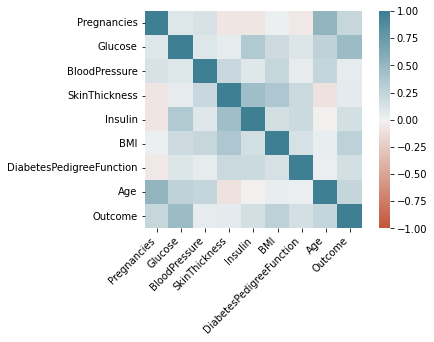

In [ ]:
# plot correlation matrix
corr = df_train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
 learning_rates = [0.2, 0.15, 0.1, 0.07, 0.05, 0.01, 0.005, 0.002]
num_iterations = [1e3, 1e4, 1e5, 1e6]
accuracies = []

for rate in learning_rates:
  for iteration in num_iterations:
    model = LogisticRegression(verbose=True, max_iters=iteration, learning_rate=rate)
    my_model = model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy()) # train model on training data with current rate
    predictions = my_model.predict(df_val[features].to_numpy())

    binary_predictions = np.where((predictions > 0.5), 1, 0)
    val_accuracy = np.mean(binary_predictions == df_val.iloc[: , -1].to_numpy())
    print("Accuracy calculated: {} (rate= {}, number of iterations={})".format(val_accuracy, rate, iteration))
    accuracies.append((rate, (iteration, val_accuracy)))


terminated after 1000 iterations, with norm of the gradient equal to 66.6805284511018
the weight found: [ 36.46398181  10.07676424 -20.4878257   -6.87946215   6.06139093
  -4.31792287   0.97391345   4.49731145  -7.34092439]
Accuracy calculated: 0.53 (rate= 0.2, number of iterations=1000.0)
terminated after 10000 iterations, with norm of the gradient equal to 67.29620775419907
the weight found: [110.41721745  10.95758835 -18.79458702  -3.88514566   5.72185703
  -3.73587867  12.99634051  -7.54812889 -71.37104246]
Accuracy calculated: 0.52 (rate= 0.2, number of iterations=10000.0)
terminated after 100000 iterations, with norm of the gradient equal to 67.57622906058326
the weight found: [ 111.3425821    13.36665466  -17.25009905   -3.15954166    5.66962201
    4.5213068   108.9876328    -6.41386607 -647.04934579]
Accuracy calculated: 0.52 (rate= 0.2, number of iterations=100000.0)
terminated after 1000000 iterations, with norm of the gradient equal to 58.430547110136374
the weight found: [

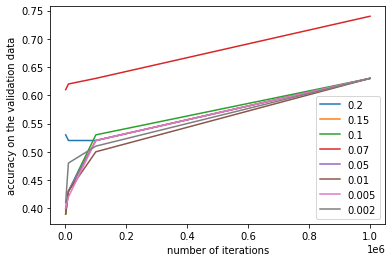

In [ ]:
values = {}
for (key, value) in accuracies:
  values.setdefault(key ,[]).append(value)

# plotting accuracy for given learning rate
for key, item in values.items():
  plt.plot(*zip(*item), label=key)

plt.legend()
plt.xlabel("number of iterations")
plt.ylabel("accuracy on the validation data")
plt.show()

In [ ]:
# select learnings rates that give above 70% accuracy on the validation data, test with testing data

candidates = []

for item in accuracies:
  if item[1][1] > 0.70:
    candidates.append(item)

candidate_accuracies = []

for rate, values in candidates:
  model = LogisticRegression(verbose=False, max_iters=values[0], learning_rate=rate)
  my_model = model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy()) # train model on training data with current rate
  predictions = my_model.predict(df_test[features].to_numpy())

  binary_predictions = np.where((predictions > 0.5), 1, 0)
  val_accuracy = np.mean(binary_predictions == df_test.iloc[: , -1].to_numpy())
  candidate_accuracies.append((rate, (values[0], val_accuracy)))
  print("Accuracy calculated: {} (rate= {}, number of iterations={})".format(val_accuracy, rate, values[0]))


Accuracy calculated: 0.7058823529411765 (rate= 0.07, number of iterations=1000000.0)


terminated after 1000000 iterations, with norm of the gradient equal to 58.85127070251861
the weight found: [ 3.72601162e+01  6.43343682e+00 -4.31407529e+00 -1.26956000e+00
 -4.96871941e-01  9.64214151e+00  1.68612984e+02  3.89326221e-01
 -1.40462741e+03]


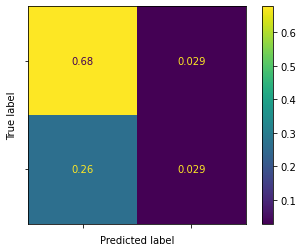

In [ ]:
#print(candidate_accuracies)

model = LogisticRegression(verbose=True, max_iters=1e6, learning_rate=0.07)
my_model = model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy()) # train model on training data with current rate
predictions = my_model.predict(df_test[features].to_numpy())

binary_predictions = np.where((predictions > 0.5), 1, 0)
val_accuracy = np.mean(binary_predictions == df_test.iloc[: , -1].to_numpy())

# plot confusion matrix
cm = confusion_matrix(df_test.iloc[: , -1].to_numpy(), binary_predictions, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=[])
cmd.plot()


In [ ]:
# cross validation

df_train_val = pd.concat([df_train, df_val], axis=0) # merge validation & training datasets for cross validation

train_x = df_train_val[features].to_numpy()
train_label = df_train_val.iloc[: , -1].to_numpy()


def cross_validate(train_x, train_label, rates):
  current_best_rate = -1
  current_best_accuracy = 0
  accuracies = []

  # make divisible by 5
  v = train_x.shape[0] % 5
  if (v != 0):
    train_x = train_x[v::]
    train_label = train_label[v::]
  print(rates)
  for rate in rates:
    # divide dataset into 5 parts
    train_x_splits = np.split(train_x, 5)
    train_label_splits = np.split(train_label, 5)

    for x in range(5):
      validation_set_X = train_x_splits[x]
      validation_set_Y = train_label_splits[x]

      training_sets_X = np.concatenate(train_x_splits[:x] +
                                      train_x_splits[x+1:], axis=0)
      training_sets_Y = np.concatenate(train_label_splits[:x] +
                                      train_label_splits[x+1:], axis=0)

      # train
      model = LogisticRegression(verbose=True, max_iters=1e6, learning_rate=rate)
      print(rate)
      my_model = model.fit(training_sets_X, training_sets_Y) # train model on training data with current rate
      
      # get results and accuracies
      predictions = my_model.predict(validation_set_X)
      binary_predictions = np.where((predictions > 0.5), 1, 0)
      current_accuracy = np.mean(binary_predictions == validation_set_Y)
      accuracies.append(current_accuracy)
      
    average = np.mean(accuracies)
    if average > current_best_accuracy:
      current_best_rate = rate
      current_best_accuracy = average
  return (current_best_rate, current_best_accuracy)


result = cross_validate(train_x, train_label, rates = [0.1, 0.07, 0.05, 0.01, 0.002])
print('Model with learning rate = {} give us the best accuracy ({}%)'.format(result[0], result[1]))

[0.1, 0.07, 0.05, 0.01, 0.002]
0.1
terminated after 1000000 iterations, with norm of the gradient equal to 58.474711991779024
the weight found: [ 5.12037392e+01  9.26610787e+00 -5.43441045e+00 -9.48530562e-01
 -2.09907458e+00  1.24545988e+01  2.87966821e+02 -1.05722047e+00
 -1.96107232e+03]
0.1
terminated after 1000000 iterations, with norm of the gradient equal to 59.284290799946305
the weight found: [ 3.86770420e+01  1.12079360e+01 -3.57080385e+00  4.02023543e-01
  9.67164204e-01  1.76909887e+01  2.88500443e+02  4.27685511e+00
 -1.90508533e+03]
0.1
terminated after 1000000 iterations, with norm of the gradient equal to 61.413043488896115
the weight found: [ 4.83653935e+01  8.21310800e+00 -6.85664341e+00 -1.48065266e+00
 -1.50557599e+00  1.70829785e+01  3.49671849e+02  5.99374781e+00
 -2.13744245e+03]
0.1
terminated after 1000000 iterations, with norm of the gradient equal to 57.2699611098561
the weight found: [ 4.48746289e+01  9.43474822e+00 -6.21213860e+00 -2.74321785e+00
 -1.742887

terminated after 1000000 iterations, with norm of the gradient equal to 58.88639127135805
the weight found: [ 5.33914629e+01  1.32311453e+01 -4.00154813e+00 -1.13912235e+00
  2.59848789e+00  1.48004812e+01  2.40976463e+02  1.65320039e+00
 -2.00674128e+03]
Accuracy: 63.5%


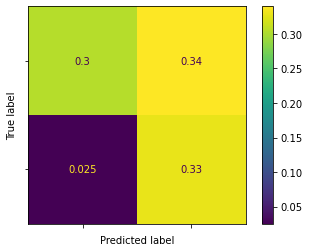

In [ ]:
# from cross-validation, rate = 0.1 and max_iters = 1e6 performs best
# run model with those params on training dataset

model = LogisticRegression(verbose=True, max_iters=1e6, learning_rate=0.1)
my_model = model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy()) # train model on training data with current rate
predictions = my_model.predict(df_train[features].to_numpy())

binary_predictions = np.where((predictions > 0.5), 1, 0)
train_accuracy = np.mean(binary_predictions == df_train.iloc[: , -1].to_numpy())

# plot confusion matrix
cm = confusion_matrix(df_train.iloc[: , -1].to_numpy(), binary_predictions, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=[])
cmd.plot()

print("Accuracy: {}%".format(train_accuracy * 100))

terminated after 1000000 iterations, with norm of the gradient equal to 58.88639127135805
the weight found: [ 5.33914629e+01  1.32311453e+01 -4.00154813e+00 -1.13912235e+00
  2.59848789e+00  1.48004812e+01  2.40976463e+02  1.65320039e+00
 -2.00674128e+03]
Accuracy: 63.0%


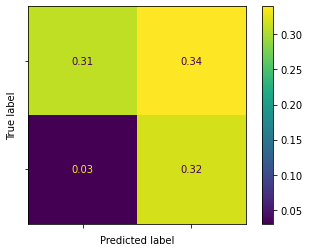

In [ ]:
# from cross-validation, rate = 0.1 and max_iters = 1e6 performs best
# run model with those params on validation dataset

model = LogisticRegression(verbose=True, max_iters=1e6, learning_rate=0.1)
my_model = model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy()) # train model on training data with current rate
predictions = my_model.predict(df_val[features].to_numpy())

binary_predictions = np.where((predictions > 0.5), 1, 0)
test_accuracy = np.mean(binary_predictions == df_val.iloc[: , -1].to_numpy())

# plot confusion matrix
cm = confusion_matrix(df_val.iloc[: , -1].to_numpy(), binary_predictions, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=[])
cmd.plot()

print("Accuracy: {}%".format(test_accuracy * 100))

terminated after 1000000 iterations, with norm of the gradient equal to 58.85127070251861
the weight found: [ 3.72601162e+01  6.43343682e+00 -4.31407529e+00 -1.26956000e+00
 -4.96871941e-01  9.64214151e+00  1.68612984e+02  3.89326221e-01
 -1.40462741e+03]
Accuracy: 70.58823529411765%


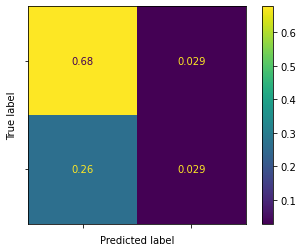

In [ ]:
# from cross-validation, rate = 0.1 and max_iters = 1e6 performs best
# run model with those params on test dataset

model = LogisticRegression(verbose=True, max_iters=1e6, learning_rate=0.07)
my_model = model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy()) # train model on training data with current rate
predictions = my_model.predict(df_test[features].to_numpy())

binary_predictions = np.where((predictions > 0.5), 1, 0)
test_accuracy = np.mean(binary_predictions == df_test.iloc[: , -1].to_numpy())

# plot confusion matrix
cm = confusion_matrix(df_test.iloc[: , -1].to_numpy(), binary_predictions, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=[])
cmd.plot()

print("Accuracy: {}%".format(test_accuracy * 100))

By including the 'insulin' feature, we notice that are overall results are not as good.

# Part 1. Optimization

## 1. Baseline implementation

Retrieving the diabeters dataset:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age']

df_train = pd.read_csv('/content/drive/MyDrive/MCGILL/COMP-551/data_A2/diabetes/diabetes_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/MCGILL/COMP-551/data_A2/diabetes/diabetes_test.csv')
df_val = pd.read_csv('/content/drive/MyDrive/MCGILL/COMP-551/data_A2/diabetes/diabetes_val.csv')

df_train

Mounted at /content/drive


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,5,144,82,26,285,32.0,0.452,58,1
1,0,128,68,19,180,30.5,1.391,25,1
2,9,156,86,28,155,34.3,1.189,42,1
3,1,144,82,46,180,46.1,0.335,46,1
4,0,179,90,27,0,44.1,0.686,23,1
...,...,...,...,...,...,...,...,...,...
595,4,158,78,0,0,32.9,0.803,31,1
596,12,84,72,31,0,29.7,0.297,46,1
597,2,158,90,0,0,31.6,0.805,66,1
598,2,83,66,23,50,32.2,0.497,22,0


Correlation matrix (diabetes dataset):

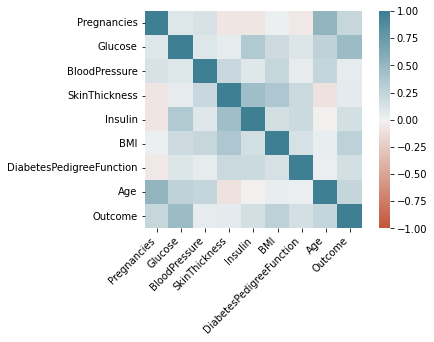

In [ ]:
# plot correlation matrix
corr = df_train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
learning_rates = [0.2, 0.15, 0.1, 0.07, 0.05, 0.01, 0.005, 0.002]
num_iterations = [1e3, 1e4, 1e5, 1e6]
accuracies = []

for rate in learning_rates:
  for iteration in num_iterations:
    model = LogisticRegression(verbose=True, max_iters=iteration, learning_rate=rate)
    my_model = model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy()) # train model on training data with current rate
    predictions = my_model.predict(df_val[features].to_numpy())

    binary_predictions = np.where((predictions > 0.5), 1, 0)
    val_accuracy = np.mean(binary_predictions == df_val.iloc[: , -1].to_numpy())
    print("Accuracy calculated: {} (rate= {}, number of iterations={})".format(val_accuracy, rate, iteration))
    accuracies.append((rate, (iteration, val_accuracy)))


terminated after 1000 iterations, with norm of the gradient equal to 45.58396640608098
the weight found: [ 28.6240045   -0.45115418 -18.20078656   0.05655761   1.27092065
   1.49365059  -0.81988166  -6.4037459 ]
Accuracy calculated: 0.62 (rate= 0.2, number of iterations=1000.0)
terminated after 10000 iterations, with norm of the gradient equal to 58.566919713880225
the weight found: [ 49.77571569  -0.25417683 -20.40295825  -0.3004283    1.42830108
  17.00237327  -5.42753219 -61.72570954]
Accuracy calculated: 0.63 (rate= 0.2, number of iterations=10000.0)
terminated after 100000 iterations, with norm of the gradient equal to 49.6876471312434
the weight found: [  78.72421661   16.0945337   -13.48234957    3.24155787    3.1524669
  124.77402543   -4.28227238 -619.16415029]
Accuracy calculated: 0.4 (rate= 0.2, number of iterations=100000.0)
terminated after 1000000 iterations, with norm of the gradient equal to 46.01477135939168
the weight found: [ 6.87548313e+01  2.15758389e+01 -5.0435411

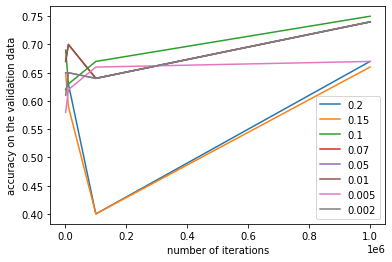

In [ ]:
values = {}
for (key, value) in accuracies:
  values.setdefault(key ,[]).append(value)

# plotting accuracy for given learning rate
for key, item in values.items():
  plt.plot(*zip(*item), label=key)

plt.legend()
plt.xlabel("number of iterations")
plt.ylabel("accuracy on the validation data")
plt.show()

terminated after 10000000 iterations, with norm of the gradient equal to 41.103083227116656
the weight found: [ 6.63717598e-01  1.36687347e-01 -7.18812763e-02 -2.85590156e-02
  3.71896850e-01  3.53389365e+00  2.73823239e-02 -3.71170074e+01]
Accuracy: 72.05882352941177%


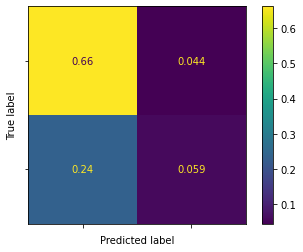

In [ ]:
# train data at 1e7 iterations to see if convergence under eps happens
model = LogisticRegression(verbose=True, max_iters=1e7, learning_rate=0.002)
my_model = model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy()) # train model on training data with current rate
predictions = my_model.predict(df_test[features].to_numpy())

binary_predictions = np.where((predictions > 0.5), 1, 0)
test_accuracy = np.mean(binary_predictions == df_test.iloc[: , -1].to_numpy())

# plot confusion matrix
cm = confusion_matrix(df_test.iloc[: , -1].to_numpy(), binary_predictions, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=[])
cmd.plot()

print("Accuracy: {}%".format(test_accuracy * 100))


In [ ]:
# select learnings rates that give above 70% accuracy on the validation data, test with testing data

candidates = []

for item in accuracies:
  if item[1][1] > 0.70:
    candidates.append(item)

candidate_accuracies = []

for rate, values in candidates:
  model = LogisticRegression(verbose=False, max_iters=values[0], learning_rate=rate)
  my_model = model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy()) # train model on training data with current rate
  predictions = my_model.predict(df_test[features].to_numpy())

  binary_predictions = np.where((predictions > 0.5), 1, 0)
  val_accuracy = np.mean(binary_predictions == df_test.iloc[: , -1].to_numpy())
  candidate_accuracies.append((rate, (values[0], val_accuracy)))
  print("Accuracy calculated: {} (rate= {}, number of iterations={})".format(val_accuracy, rate, values[0]))


Accuracy calculated: 0.7205882352941176 (rate= 0.1, number of iterations=1000000.0)
Accuracy calculated: 0.7205882352941176 (rate= 0.07, number of iterations=1000000.0)
Accuracy calculated: 0.7205882352941176 (rate= 0.05, number of iterations=1000000.0)
Accuracy calculated: 0.7205882352941176 (rate= 0.01, number of iterations=1000000.0)
Accuracy calculated: 0.7205882352941176 (rate= 0.002, number of iterations=1000000.0)


terminated after 1000000 iterations, with norm of the gradient equal to 44.31538400565922
the weight found: [ 3.43505624e+01  7.01724140e+00 -4.58432392e+00 -1.14387102e+00
  1.46995368e+01  2.00331055e+02  1.05188412e+00 -1.71094986e+03]


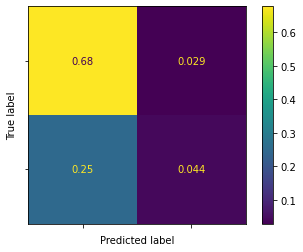

In [ ]:
#print(candidate_accuracies)

model = LogisticRegression(verbose=True, max_iters=1e6, learning_rate=0.1)
my_model = model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy()) # train model on training data with current rate
predictions = my_model.predict(df_test[features].to_numpy())

binary_predictions = np.where((predictions > 0.5), 1, 0)
val_accuracy = np.mean(binary_predictions == df_test.iloc[: , -1].to_numpy())

# plot confusion matrix
cm = confusion_matrix(df_test.iloc[: , -1].to_numpy(), binary_predictions, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=[])
cmd.plot()


In [ ]:
# cross validation

df_train_val = pd.concat([df_train, df_val], axis=0) # merge validation & training datasets for cross validation

train_x = df_train_val[features].to_numpy()
train_label = df_train_val.iloc[: , -1].to_numpy()


def cross_validate(train_x, train_label, rates):
  current_best_rate = -1
  current_best_accuracy = 0
  accuracies = []

  # make divisible by 5
  v = train_x.shape[0] % 5
  if (v != 0):
    train_x = train_x[v::]
    train_label = train_label[v::]
  print(rates)
  for rate in rates:
    # divide dataset into 5 parts
    train_x_splits = np.split(train_x, 5)
    train_label_splits = np.split(train_label, 5)

    for x in range(5):
      validation_set_X = train_x_splits[x]
      validation_set_Y = train_label_splits[x]

      training_sets_X = np.concatenate(train_x_splits[:x] +
                                      train_x_splits[x+1:], axis=0)
      training_sets_Y = np.concatenate(train_label_splits[:x] +
                                      train_label_splits[x+1:], axis=0)

      # train
      model = LogisticRegression(verbose=True, max_iters=1e6, learning_rate=rate)
      print(rate)
      my_model = model.fit(training_sets_X, training_sets_Y) # train model on training data with current rate
      
      # get results and accuracies
      predictions = my_model.predict(validation_set_X)
      binary_predictions = np.where((predictions > 0.5), 1, 0)
      current_accuracy = np.mean(binary_predictions == validation_set_Y)
      accuracies.append(current_accuracy)
      
    average = np.mean(accuracies)
    if average > current_best_accuracy:
      current_best_rate = rate
      current_best_accuracy = average
  return (current_best_rate, current_best_accuracy)


result = cross_validate(train_x, train_label, rates = [0.1, 0.07, 0.05, 0.01, 0.002])
print('Model with learning rate = {} give us the best accuracy ({}%)'.format(result[0], result[1]))

[0.1, 0.07, 0.05, 0.01, 0.002]
0.1
terminated after 1000000 iterations, with norm of the gradient equal to 45.3011890303373
the weight found: [ 3.69955980e+01  6.82131768e+00 -3.96616614e+00 -1.64837052e+00
  1.33058993e+01  2.34441393e+02 -1.20434783e+00 -1.64666810e+03]
0.1
terminated after 1000000 iterations, with norm of the gradient equal to 47.15083195235423
the weight found: [ 2.86330158e+01  6.12249049e+00 -4.83663286e+00 -4.69624373e-01
  1.56291566e+01  1.90847772e+02  2.69808042e+00 -1.67447176e+03]
0.1
terminated after 1000000 iterations, with norm of the gradient equal to 46.70340886210453
the weight found: [ 2.85533514e+01  9.86307714e+00 -2.82716947e+00 -8.04304592e-01
  2.12582126e+01  2.39567237e+02  5.24195779e+00 -1.85283533e+03]
0.1
terminated after 1000000 iterations, with norm of the gradient equal to 40.25528468339208
the weight found: [   29.80173932    10.62592174    -3.03907078    -1.68262045
    16.27983385   176.86525062     2.58605406 -1671.08423161]
0.1
te

terminated after 1000000 iterations, with norm of the gradient equal to 44.75357487317937
the weight found: [ 7.19562802e-01  1.35377202e-01 -9.00926539e-02 -2.08911460e-02
  3.06101583e-01  3.69511048e+00  9.87417598e-03 -3.39474195e+01]
Accuracy: 69.66666666666667%


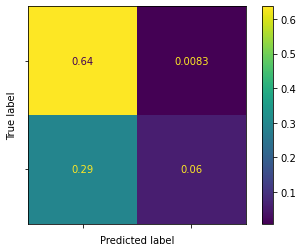

In [ ]:
# from cross-validation, rate = 0.002 and max_iters = 1e6 performs best
# run model with those params on training dataset

model = LogisticRegression(verbose=True, max_iters=1e6, learning_rate=0.002)
my_model = model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy()) # train model on training data with current rate
predictions = my_model.predict(df_train[features].to_numpy())

binary_predictions = np.where((predictions > 0.5), 1, 0)
train_accuracy = np.mean(binary_predictions == df_train.iloc[: , -1].to_numpy())

# plot confusion matrix
cm = confusion_matrix(df_train.iloc[: , -1].to_numpy(), binary_predictions, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=[])
cmd.plot()

print("Accuracy: {}%".format(train_accuracy * 100))

terminated after 1000000 iterations, with norm of the gradient equal to 44.75357487317937
the weight found: [ 7.19562802e-01  1.35377202e-01 -9.00926539e-02 -2.08911460e-02
  3.06101583e-01  3.69511048e+00  9.87417598e-03 -3.39474195e+01]
Accuracy: 74.0%


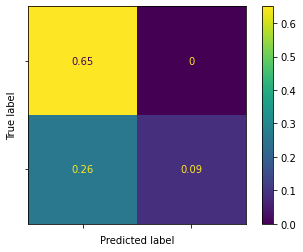

In [ ]:
# from cross-validation, rate = 0.002 and max_iters = 1e6 performs best
# run model with those params on validation dataset

model = LogisticRegression(verbose=True, max_iters=1e6, learning_rate=0.002)
my_model = model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy()) # train model on training data with current rate
predictions = my_model.predict(df_val[features].to_numpy())

binary_predictions = np.where((predictions > 0.5), 1, 0)
test_accuracy = np.mean(binary_predictions == df_val.iloc[: , -1].to_numpy())

# plot confusion matrix
cm = confusion_matrix(df_val.iloc[: , -1].to_numpy(), binary_predictions, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=[])
cmd.plot()

print("Accuracy: {}%".format(test_accuracy * 100))

terminated after 1000000 iterations, with norm of the gradient equal to 44.75357487317937
the weight found: [ 7.19562802e-01  1.35377202e-01 -9.00926539e-02 -2.08911460e-02
  3.06101583e-01  3.69511048e+00  9.87417598e-03 -3.39474195e+01]
Accuracy: 72.05882352941177%


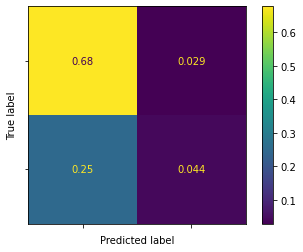

In [ ]:
# from cross-validation, rate = 0.002 and max_iters = 1e6 performs best
# run model with those params on test dataset

model = LogisticRegression(verbose=True, max_iters=1e6, learning_rate=0.002)
my_model = model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy()) # train model on training data with current rate
predictions = my_model.predict(df_test[features].to_numpy())

binary_predictions = np.where((predictions > 0.5), 1, 0)
test_accuracy = np.mean(binary_predictions == df_test.iloc[: , -1].to_numpy())

# plot confusion matrix
cm = confusion_matrix(df_test.iloc[: , -1].to_numpy(), binary_predictions, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=[])
cmd.plot()

print("Accuracy: {}%".format(test_accuracy * 100))



---



## 2. Mini-batch Gradient Descent

Implementing mini-batch stochastic gradient descent : 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age']

df_train = pd.read_csv('/content/drive/MyDrive/diabetes/diabetes_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/diabetes/diabetes_test.csv')
df_val = pd.read_csv('/content/drive/MyDrive/diabetes/diabetes_val.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class mini_batch_gradient_descent:

    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, num_epochs=1e5, verbose=False, batch_size=32):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.num_epochs = num_epochs                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        self.batch_size=batch_size

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N 
        #print(grad)       # divide by N because cost is mean over N points
        return grad
  
    def create_mini_batches(self,x, y, batch_size):
        mini_batches = []
        data = np.column_stack((x, y))
        np.random.shuffle(data)
        n_minibatches = x.shape[0] // batch_size
        i = 0
  
        for i in range(n_minibatches):
            mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
            x_mini = mini_batch[:, :-1]
            y_mini = mini_batch[:, -1]
            mini_batches.append((x_mini, y_mini))
        if data.shape[0] % batch_size != 0:
            mini_batch = data[i * batch_size:data.shape[0]]
            x_mini = mini_batch[:, :-1]
            y_mini = mini_batch[:, -1]
            mini_batches.append((x_mini, y_mini))
        return mini_batches
       
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        # the code snippet below is for mini batch gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.num_epochs:
            mini_batches = self.create_mini_batches(x,y,self.batch_size)
            for mini_batch in mini_batches:
                x_mini, y_mini = mini_batch
                g = self.gradient(x_mini,y_mini)
                self.w = self.w - self.learning_rate * g
            t += 1

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

Comparing across different minibatch sizes with best model obtained from part 1.1: **learning_rate = 0.002** and **max_iters = 1e6**

In [ ]:
learning_rate = 0.002
num_epochs = 1e6
accuracies_sizes = []
batch_sizes = [8, 16, 32, 64, 128, 256]
times=[]

for size in batch_sizes:
      start = time.time()
      mini_model = mini_batch_gradient_descent(verbose=True, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=size)
      my_mini_model = mini_model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy()) # train model on training data with current rate
      predictions = my_mini_model.predict(df_val[features].to_numpy())
      end = time.time()

      binary_predictions = np.where((predictions > 0.5), 1, 0)
      time_cost=end-start
      times.append(time_cost)
      val_accuracy = np.mean(binary_predictions == df_val.iloc[: , -1].to_numpy())
      print("Validation Accuracy calculated: {} (batch size = {})".format(val_accuracy, size))
      accuracies_sizes.append((size, val_accuracy))    

terminated after 233 iterations, with norm of the gradient equal to 2.2664970865017295e-05
the weight found: [ 0.93405142  0.04183352 -0.26638916  0.02968516 -0.02826329  0.28379682
 -0.10649682 -1.23477468]
Validation Accuracy calculated: 0.62 (batch size = 8)
terminated after 55241 iterations, with norm of the gradient equal to 8.996043889071264e-09
the weight found: [ 6.68107015e-01  4.10121732e-02 -1.15841378e-01 -2.69237634e-02
  3.59779925e-01  4.03304648e+00  1.04883324e-02 -3.61990131e+01]
Validation Accuracy calculated: 0.65 (batch size = 16)
terminated after 1000000 iterations, with norm of the gradient equal to 29.091836467223384
the weight found: [ 6.61491312e-01  1.81544187e-01 -2.22272225e-02 -1.80113045e-02
  3.65267935e-01  3.86979351e+00  7.92761278e-02 -3.49482290e+01]
Validation Accuracy calculated: 0.68 (batch size = 32)
terminated after 1000000 iterations, with norm of the gradient equal to 34.531105653257804
the weight found: [ 6.37801333e-01  1.18403557e-01 -6.58

Plot Validation Accuracy vs. mini batch size on validation data

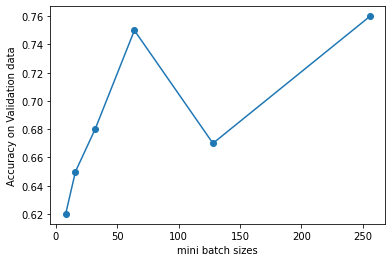

Highest Validation Accuracy Achieved: 76.0%   at (batch size = 256 with learning rate= 0.002, number of epochs=1e6)


In [ ]:
#unpack accuracies_sizes into lists
sizes, accuracies = zip(*accuracies_sizes)

# plotting accuracy for given learning rate
plt.plot(sizes, accuracies,marker='o')

plt.xlabel("mini batch sizes")
plt.ylabel("Accuracy on Validation data")

highest_accu = accuracies[0]
highest_size = 4

for i in range(len(accuracies)):
  if (accuracies[i]>highest_accu):
    highest_accu = accuracies[i]
    highest_size = sizes[i]
    

plt.show()
print("Highest Validation Accuracy Achieved: {}%   at (batch size = {} with learning rate= 0.002, number of epochs=1e6)".format(highest_accu * 100, highest_size))

Plot Convergence speed (in terms of number of seconds it takes to run) vs. mini batch sizes

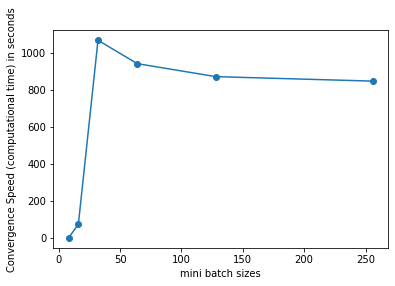

In [ ]:
plt.plot(sizes, times, marker='o')

plt.xlabel("mini batch sizes")
plt.ylabel("Convergence Speed (computational time) in seconds")
plt.show()

Find convergence time on fully batched baseline with the best model found in part 1

In [ ]:
# Best model Full batch found on cross-validation: learning_rate = 0.002 and max_iters = 1e6

rate = 0.002
num_epochs = 1e6
start = time.time()
model = LogisticRegression(learning_rate=rate, max_iters=num_epochs, verbose=True)
my_model = model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy())
end = time.time()
# validation acc
predictions = my_model.predict(df_val[features].to_numpy())
binary_predictions = np.where((predictions > 0.5), 1, 0)
val_accuracy = np.mean(binary_predictions == df_val.iloc[: , -1].to_numpy())
# train acc
predictions = my_model.predict(df_train[features].to_numpy())
binary_predictions = np.where((predictions > 0.5), 1, 0)
train_accuracy = np.mean(binary_predictions == df_train.iloc[: , -1].to_numpy())
# test acc
predictions = my_model.predict(df_test[features].to_numpy())
binary_predictions = np.where((predictions > 0.5), 1, 0)
test_accuracy = np.mean(binary_predictions == df_test.iloc[: , -1].to_numpy())

time_len = end-start
print("convergence speed in terms of number of seconds take to run: {}".format(time_len))

print("Training Accuracy: {}% ".format(train_accuracy * 100))
print("Validation Accuracy: {}% ".format(val_accuracy * 100))
print("Testing Accuracy: {}% ".format(test_accuracy * 100))

terminated after 1000000 iterations, with norm of the gradient equal to 44.75357487317937
the weight found: [ 7.19562802e-01  1.35377202e-01 -9.00926539e-02 -2.08911460e-02
  3.06101583e-01  3.69511048e+00  9.87417598e-03 -3.39474195e+01]
convergence speed in terms of number of seconds take to run: 33.299784660339355
Training Accuracy: 69.66666666666667% 
Validation Accuracy: 74.0% 
Testing Accuracy: 72.05882352941177% 


## 3. Gradient Descent with Momentum

In [ ]:
class LogisticRegression_with_Momentum:
    
    def __init__(self, add_bias=True, learning_rate=0.002, epsilon=1e-4, max_iters=1e6, verbose=False, momentum_coeff=0.9):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        self.momentum_coeff = momentum_coeff
        
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        self.delta_w = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.delta_w = self.momentum_coeff * self.delta_w + (1-self.momentum_coeff) * g # implementing the momentum
            self.w = self.w - self.learning_rate * self.delta_w
            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

LogisticRegression_with_Momentum.gradient = gradient             #initialize the gradient method of the LogisticRegression class with gradient function

In [ ]:
# The baseline for this part (Full batch gradient descent LogisticRegression with learning rate=0.002 and max_iters=1e6)

rate = 0.002
num_epochs = 1e6
start = time.time()
model = LogisticRegression(learning_rate=rate, max_iters=num_epochs, verbose=True)
base_model = model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy()) # train model on training data with baseline model
end = time.time()
# validation acc
predictions = base_model.predict(df_val[features].to_numpy())
binary_predictions = np.where((predictions > 0.5), 1, 0)
val_accuracy = np.mean(binary_predictions == df_val.iloc[: , -1].to_numpy())
# train acc
predictions = base_model.predict(df_train[features].to_numpy())
binary_predictions = np.where((predictions > 0.5), 1, 0)
train_accuracy = np.mean(binary_predictions == df_train.iloc[: , -1].to_numpy())
# test acc
predictions = base_model.predict(df_test[features].to_numpy())
binary_predictions = np.where((predictions > 0.5), 1, 0)
test_accuracy = np.mean(binary_predictions == df_test.iloc[: , -1].to_numpy())

time_len = end-start
print("convergence speed in terms of number of seconds take to run: {}".format(time_len))

print("Training Accuracy: {}% ".format(train_accuracy * 100))
print("Validation Accuracy: {}% ".format(val_accuracy * 100))
print("Testing Accuracy: {}% ".format(test_accuracy * 100))

terminated after 1000000 iterations, with norm of the gradient equal to 44.75357487317937
the weight found: [ 7.19562802e-01  1.35377202e-01 -9.00926539e-02 -2.08911460e-02
  3.06101583e-01  3.69511048e+00  9.87417598e-03 -3.39474195e+01]
convergence speed in terms of number of seconds take to run: 33.34634876251221
Training Accuracy: 69.66666666666667% 
Validation Accuracy: 74.0% 
Testing Accuracy: 72.05882352941177% 


In [ ]:
momentum_coeffs = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
val_accuracies = []
tr_accuracies = []
running_time = []

for beta in momentum_coeffs:
  start = time.time()
  model = LogisticRegression_with_Momentum(verbose=True, momentum_coeff=beta)
  my_model = model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy()) # train model on training data with current momentum coefficient
  end = time.time()
  temp = end - start
  running_time.append(temp)
  
  predictions = my_model.predict(df_val[features].to_numpy())
  binary_predictions = np.where((predictions > 0.5), 1, 0)
  val_accuracy = np.mean(binary_predictions == df_val.iloc[: , -1].to_numpy())
  print("Validation Accuracy calculated: {} (beta= {})".format(val_accuracy, beta))
  val_accuracies.append((beta, val_accuracy))

  predictions = my_model.predict(df_train[features].to_numpy())
  binary_predictions = np.where((predictions > 0.5), 1, 0)
  tr_accuracy = np.mean(binary_predictions == df_train.iloc[: , -1].to_numpy())
  print("Training Accuracy calculated: {} (beta= {})".format(tr_accuracy, beta))
  tr_accuracies.append((beta, tr_accuracy))

terminated after 1000000 iterations, with norm of the gradient equal to 44.75357487317937
the weight found: [ 7.19562802e-01  1.35377202e-01 -9.00926539e-02 -2.08911460e-02
  3.06101583e-01  3.69511048e+00  9.87417598e-03 -3.39474195e+01]
Validation Accuracy calculated: 0.74 (beta= 0)
Training Accuracy calculated: 0.6966666666666667 (beta= 0)
terminated after 1000000 iterations, with norm of the gradient equal to 42.60660233120533
the weight found: [ 5.63112894e-01  1.10061169e-01 -6.66967099e-02 -1.94570069e-02
  2.72300434e-01  2.95765375e+00  1.51992351e-02 -2.86968875e+01]
Validation Accuracy calculated: 0.75 (beta= 0.1)
Training Accuracy calculated: 0.7033333333333334 (beta= 0.1)
terminated after 1000000 iterations, with norm of the gradient equal to 40.38528048161312
the weight found: [ 4.42522204e-01  1.33048922e-01 -2.55794152e-02 -9.72413219e-03
  2.45438690e-01  2.37977550e+00  2.92388373e-02 -2.37973049e+01]
Validation Accuracy calculated: 0.69 (beta= 0.2)
Training Accuracy 

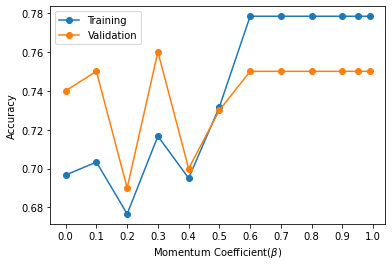

In [ ]:
#unpack accuracies into lists
mom_coeff, val_acc = zip(*val_accuracies)
mom_coeff, tr_acc = zip(*tr_accuracies)

# plotting accuracy for given learning rate
plt.xticks(np.arange(min(mom_coeff), max(mom_coeff)+0.1, 0.1))
plt.plot(mom_coeff, tr_acc, marker='o')
plt.plot(mom_coeff, val_acc, marker='o')

plt.legend(['Training','Validation'])
plt.xlabel(r"Momentum Coefficient($\beta$)")
plt.ylabel("Accuracy")

plt.show()

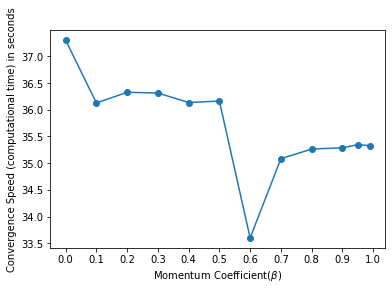

In [ ]:
plt.xticks(np.arange(min(mom_coeff), max(mom_coeff)+0.1, 0.1))
plt.plot(mom_coeff, running_time, marker='o')

plt.xlabel(r"Momentum Coefficient($\beta$)")
plt.ylabel("Convergence Speed (computational time) in seconds")
plt.show()

Since there are a lot of $\beta$ values achieving the same accuracy and have approximately the same convergence speed (these models converge before reaching **max_iterations**), we try a lower max_iterations value.

In [ ]:
momentum_coeffs = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
val_accuracies = []
tr_accuracies = []
running_time = []
max_it = 4e4

for beta in momentum_coeffs:
  start = time.time()
  model = LogisticRegression_with_Momentum(verbose=True, momentum_coeff=beta, max_iters=max_it)
  my_model = model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy()) # train model on training data with current momentum coefficient
  end = time.time()
  temp = end - start
  running_time.append(temp)
  
  predictions = my_model.predict(df_val[features].to_numpy())
  binary_predictions = np.where((predictions > 0.5), 1, 0)
  val_accuracy = np.mean(binary_predictions == df_val.iloc[: , -1].to_numpy())
  print("Validation Accuracy calculated: {} (beta= {})".format(val_accuracy, beta))
  val_accuracies.append((beta, val_accuracy))

  predictions = my_model.predict(df_train[features].to_numpy())
  binary_predictions = np.where((predictions > 0.5), 1, 0)
  tr_accuracy = np.mean(binary_predictions == df_train.iloc[: , -1].to_numpy())
  print("Training Accuracy calculated: {} (beta= {})".format(tr_accuracy, beta))
  tr_accuracies.append((beta, tr_accuracy))

terminated after 40000 iterations, with norm of the gradient equal to 27.736158989784414
the weight found: [ 0.81886263  0.06812872 -0.1925743   0.02559304 -0.02020255  0.60964256
 -0.0804839  -2.7336038 ]
Validation Accuracy calculated: 0.65 (beta= 0)
Training Accuracy calculated: 0.6616666666666666 (beta= 0)
terminated after 40000 iterations, with norm of the gradient equal to 30.88284229317137
the weight found: [ 4.51654866e-01  2.51851770e-02 -1.28854881e-01  1.46154319e-03
  1.74544207e-02  5.85992538e-01 -4.38460145e-02 -2.49908615e+00]
Validation Accuracy calculated: 0.63 (beta= 0.1)
Training Accuracy calculated: 0.6566666666666666 (beta= 0.1)
terminated after 40000 iterations, with norm of the gradient equal to 27.803540393097787
the weight found: [ 0.43500375  0.09049279 -0.06824111  0.01466548  0.03575575  0.57492295
 -0.02253893 -2.52851903]
Validation Accuracy calculated: 0.38 (beta= 0.2)
Training Accuracy calculated: 0.36 (beta= 0.2)
terminated after 40000 iterations, with

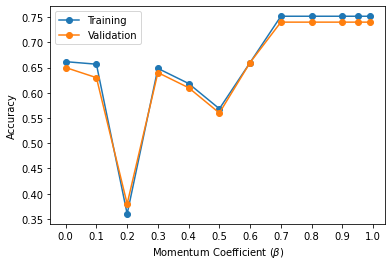

In [ ]:
#unpack accuracies into lists
mom_coeff, val_acc = zip(*val_accuracies)
mom_coeff, tr_acc = zip(*tr_accuracies)

# plotting accuracy for given learning rate
plt.xticks(np.arange(min(mom_coeff), max(mom_coeff)+0.1, 0.1))
plt.plot(mom_coeff, tr_acc, marker='o')
plt.plot(mom_coeff, val_acc, marker='o')

plt.legend(['Training','Validation'])
plt.xlabel(r"Momentum Coefficient ($\beta$)")
plt.ylabel("Accuracy")

plt.show()

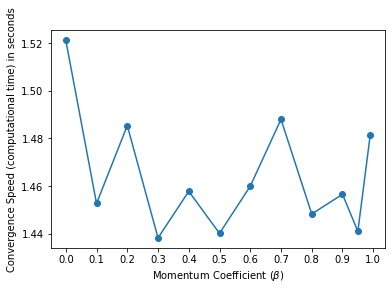

In [ ]:
plt.xticks(np.arange(min(mom_coeff), max(mom_coeff)+0.1, 0.1))
plt.plot(mom_coeff, running_time, marker='o')

plt.xlabel(r"Momentum Coefficient ($\beta$)")
plt.ylabel("Convergence Speed (computational time) in seconds")
plt.show()

Considering the validation accuracy (the higher the better) and the convergence time (the lower the better), the best $\beta$ value is **0.95**

In [ ]:
# Reaching the same va_accuracy woth baseline model, in the less iterations
accuracies = []
running_time = []
iter = 4e4
best_beta = 0.95

model = LogisticRegression_with_Momentum(max_iters=iter, verbose=True, momentum_coeff=best_beta)
my_model = model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy()) # train model on training data with current momentum coefficient
predictions = my_model.predict(df_val[features].to_numpy())

binary_predictions = np.where((predictions > 0.5), 1, 0)
val_accuracy = np.mean(binary_predictions == df_val.iloc[: , -1].to_numpy())
print("Validation Accuracy calculated: {} (beta= {})".format(val_accuracy, best_beta))

terminated after 40000 iterations, with norm of the gradient equal to 0.023864213065989598
the weight found: [ 1.25339919e-01  2.02496112e-02 -2.38928905e-02  1.01839993e-03
  1.66526615e-02  3.51714894e-01 -6.01293386e-03 -2.36888782e+00]
Validation Accuracy calculated: 0.74 (beta= 0.95)


Full Batch gradient descent with momentum achieves the same validation accuracy of the baseline model (Full Batch gradient descent) $\frac{1e6}{4e4}=25$ times faster.

## 4. Mini-batch Gradient Descent with Momentum

In [ ]:
class mini_batch_LogisticRegression_with_Momentum:
    
    def __init__(self, add_bias=True, learning_rate=0.002, epsilon=1e-4, max_iters=1e6, verbose=False, batch_size = 128, momentum_coeff=0.9):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        self.batch_size=batch_size
        self.momentum_coeff = momentum_coeff

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N       # divide by N because cost is mean over N points
        return grad
        
    def create_mini_batches(self,x, y, batch_size):
        mini_batches = []
        data = np.column_stack((x, y))
        np.random.shuffle(data)
        n_minibatches = x.shape[0] // batch_size
        i = 0
  
        for i in range(n_minibatches):
            mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
            x_mini = mini_batch[:, :-1]
            y_mini = mini_batch[:, -1]
            mini_batches.append((x_mini, y_mini))
        if data.shape[0] % batch_size != 0:
            mini_batch = data[i * batch_size:data.shape[0]]
            x_mini = mini_batch[:, :-1]
            y_mini = mini_batch[:, -1]
            mini_batches.append((x_mini, y_mini))
        return mini_batches

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        self.delta_w = 0
        # the code snippet below is for mini batch gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            mini_batches = self.create_mini_batches(x,y,self.batch_size)
            for mini_batch in mini_batches:
                x_mini,y_mini = mini_batch
                g = self.gradient(x_mini, y_mini)
                self.delta_w = self.momentum_coeff * self.delta_w + (1-self.momentum_coeff) * g
                self.w = self.w - self.learning_rate * self.delta_w
            t += 1

        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

mini_batch_LogisticRegression_with_Momentum.gradient = gradient             #initialize the gradient method of the mini_batch_LogisticRegression_with_Momentum class with gradient function

In [ ]:
# the smallest batch size
the_batch_size = 8
momentum_coeffs = [0.1, 0.3, 0.5, 0.8, 0.95]
accuracies = []
running_time = []

for beta in momentum_coeffs:
  start = time.time()
  model = mini_batch_LogisticRegression_with_Momentum(verbose=True, batch_size=the_batch_size, momentum_coeff=beta)
  my_model = model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy()) # train model on training data with current momentum coefficient
  end = time.time()
  predictions = my_model.predict(df_val[features].to_numpy())

  temp = end - start
  running_time.append(temp)
  binary_predictions = np.where((predictions > 0.5), 1, 0)
  val_accuracy = np.mean(binary_predictions == df_val.iloc[: , -1].to_numpy())
  print("Validation Accuracy calculated: {} (beta= {})".format(val_accuracy, beta))
  accuracies.append((beta, val_accuracy))

terminated after 411 iterations, with norm of the gradient equal to 3.526518917806476e-05
the weight found: [ 0.75646371 -0.04068309 -0.2002304   0.02068979 -0.01446236  0.49924989
 -0.06059077 -2.1309754 ]
Validation Accuracy calculated: 0.65 (beta= 0.1)
terminated after 2 iterations, with norm of the gradient equal to 7.230973421656491e-05
the weight found: [ 0.05840752 -0.05880211 -0.15047112 -0.02799852 -0.05913604 -0.00027592
 -0.03924027 -0.01259354]
Validation Accuracy calculated: 0.65 (beta= 0.3)
terminated after 15127 iterations, with norm of the gradient equal to 3.6807013379480637e-07
the weight found: [ 3.93457542e-01 -1.80621814e-02 -1.20329573e-01 -2.61240747e-02
  1.77053862e-01  2.41977759e+00 -6.96583945e-04 -2.15809245e+01]
Validation Accuracy calculated: 0.65 (beta= 0.5)
terminated after 4049 iterations, with norm of the gradient equal to 1.051258322257682e-05
the weight found: [ 2.64050243e-01  1.03744806e-02 -1.46417718e-01 -1.13737928e-02
  5.02584154e-02  1.35616

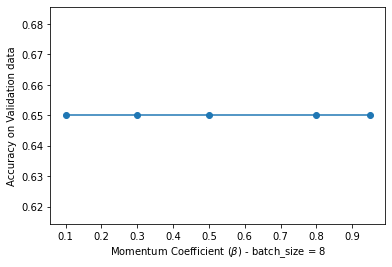

In [ ]:
#unpack accuracies into lists
mom_coeff, val_acc = zip(*accuracies)

# plotting accuracy for given learning rate
plt.xticks(np.arange(min(mom_coeff), max(mom_coeff)+0.1, 0.1))
plt.plot(mom_coeff, val_acc, marker='o')

plt.xlabel(r"Momentum Coefficient ($\beta$) - batch_size = $8$")
plt.ylabel("Accuracy on Validation data")

plt.show()

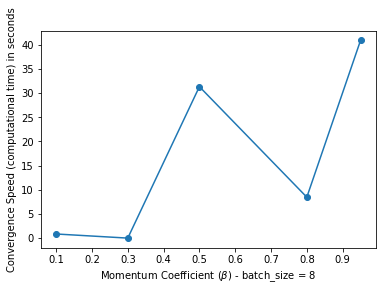

In [ ]:
plt.xticks(np.arange(min(mom_coeff), max(mom_coeff)+0.1, 0.1))
plt.plot(mom_coeff, running_time, marker='o')

plt.xlabel(r"Momentum Coefficient ($\beta$) - batch_size = $8$")
plt.ylabel("Convergence Speed (computational time) in seconds")
plt.show()

In [ ]:
# the largest batch size
the_batch_size = 256
momentum_coeffs = [0.1, 0.3, 0.5, 0.8, 0.95]
accuracies = []
running_time = []

for beta in momentum_coeffs:
  start = time.time()
  model = mini_batch_LogisticRegression_with_Momentum(verbose=True, batch_size=the_batch_size, momentum_coeff=beta)
  my_model = model.fit(df_train[features].to_numpy(), df_train.iloc[: , -1].to_numpy()) # train model on training data with current momentum coefficient
  end = time.time()
  predictions = my_model.predict(df_val[features].to_numpy())

  temp = end - start
  running_time.append(temp)
  binary_predictions = np.where((predictions > 0.5), 1, 0)
  val_accuracy = np.mean(binary_predictions == df_val.iloc[: , -1].to_numpy())
  print("Validation Accuracy calculated: {} (beta= {})".format(val_accuracy, beta))
  accuracies.append((beta, val_accuracy))

In [ ]:
#unpack accuracies into lists
mom_coeff, val_acc = zip(*accuracies)

# plotting accuracy for given learning rate
plt.xticks(np.arange(min(mom_coeff), max(mom_coeff)+0.1, 0.1))
plt.plot(mom_coeff, val_acc, marker='o')

plt.xlabel(r"Momentum Coefficient ($\beta$) - batch_size = $256$")
plt.ylabel("Accuracy on Validation data")

plt.show()

In [ ]:
plt.xticks(np.arange(min(mom_coeff), max(mom_coeff)+0.1, 0.1))
plt.plot(mom_coeff, running_time, marker='o')

plt.xlabel(r"Momentum Coefficient ($\beta$) - batch_size = $256$")
plt.ylabel("Convergence Speed (computational time) in seconds")
plt.show()

In [ ]:
# The full batch is considered in the Part 1.3

# Part 2. Text classification

## 2.1 Retrieving fakenews dataset

In [ ]:
# import dataset

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

df_train = pd.read_csv('/content/drive/MyDrive/MCGILL/COMP-551/data_A2/fake_news/fake_news_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/MCGILL/COMP-551/data_A2/fake_news/fake_news_test.csv')
df_val = pd.read_csv('/content/drive/MyDrive/MCGILL/COMP-551/data_A2/fake_news/fake_news_val.csv')

df_val

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,text,label
0,When don't you have something appropriate to w...,0
1,Share this article with Google Plus\nA brief g...,0
2,NEW YORK — Yankees beat reporter Brendan Kuty ...,1
3,The Goonies has always posed challenges for fi...,0
4,"Parisians sang, lit candles and prayed to pay ...",1
...,...,...
1995,"KABUL - In past several weeks, hectic negotiat...",1
1996,1) Where is Wan-Bissaka in the young player sh...,1
1997,It may seem counterintuitive that Calgary shou...,0
1998,The CEOs of America's biggest banks were summo...,1


In [ ]:
# cleaning up the training data

# checking if any column has null values 
for col in df_train.columns:
    print(col, df_train[col].isnull().sum()) # prints 0 for both columns, no further action required for this

# remove \n occurences
#df_train['text'] = df_train['text'].apply(lambda x: x.replace('\n', ' ')) # Again, consider using or not

df_train

text 0
label 0


,text,label
0,Indian fruit is so important to so many people...,0
1,"FORT WORTH, Texas — Urú Inc. will hold a confe...",0
2,"With three of the four new carriers, the Niger...",0
3,Let's start with the classic annual dividend r...,0
4,Following are some of the major events to have...,1
...,...,...
19995,"Warning: small, petty spoilers for the Game of...",1
19996,Shilpa Shetty will soon make her Bollywood deb...,0
19997,Add a digital black hole image to the Allstate...,0
19998,Share\nThe name W. L. Gore & Associates might ...,1


## 2.2 Experiments

In [ ]:
# testing a barebone implementation

# build dictionary of features and transform documents to feature vectors using CountVectorizer from sklearn
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df_train['text'])

# convert occurences to frequencies 
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# train logistic regression model
clf = LogisticRegression().fit(X_train_tfidf, df_train['label'])

# extract features from test & val dataset to calculate predictions
X_test_counts = count_vect.transform(df_test['text'])
X_val_counts = count_vect.transform(df_val['text'])

# convert occurences to frequencies 
tfidf_transformer = TfidfTransformer()
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
X_val_tfidf = tfidf_transformer.fit_transform(X_val_counts)


# make predictions on validation, training and test dataset
predictions_test = clf.predict(X_test_tfidf)
accuracy_test = np.mean(predictions_test == df_test['label'])

predictions_val = clf.predict(X_val_counts)
accuracy_val = np.mean(predictions_val == df_val['label'])

predictions_train = clf.predict(X_train_tfidf)
accuracy_train = np.mean(predictions_train == df_train['label'])

print('test accuracy: ' + str(accuracy_test))
print('val accuracy: ' + str(accuracy_val))
print('train accuracy: ' + str(accuracy_train))

test accuracy: 0.711
val accuracy: 0.4315
train accuracy: 0.85515


In [ ]:
# testing with english stop words list from nltk library
# NOTE: not necessarily good to use because computer-generated text might have recognizable patterns using these words

# Setup
!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords') # stop words are not very informative so we wish to ignore them before we build feature vectors

# build dictionary of features and transform documents to feature vectors using CountVectorizer from sklearn
count_vect = CountVectorizer(stop_words=stopwords.words('english'))
X_train_counts = count_vect.fit_transform(df_train['text'])

# convert occurences to frequencies 
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# train logistic regression model
clf = LogisticRegression().fit(X_train_tfidf, df_train['label'])

# extract features from test & val dataset to calculate predictions
X_test_counts = count_vect.transform(df_test['text'])
X_val_counts = count_vect.transform(df_val['text'])

# convert occurences to frequencies 
tfidf_transformer = TfidfTransformer()
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
X_val_tfidf = tfidf_transformer.fit_transform(X_val_counts)


# make predictions on both validation and test dataset
predictions_test = clf.predict(X_test_tfidf)
accuracy_test = np.mean(predictions_test == df_test['label'])

predictions_val = clf.predict(X_val_counts)
accuracy_val = np.mean(predictions_val == df_val['label'])

predictions_train = clf.predict(X_train_tfidf)
accuracy_train = np.mean(predictions_train == df_train['label'])

print('test accuracy: ' + str(accuracy_test))
print('val accuracy: ' + str(accuracy_val))
print('train accuracy: ' + str(accuracy_train))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
test accuracy: 0.6983333333333334
val accuracy: 0.5925
train accuracy: 0.8621


In [ ]:
# testing various parameters for max_df and min_df

# e.g max_df = 0.5 -> remove terms that are in more than half the articles

n_min = [0, 0.05, 0.1, 0.15, 0.25]
n_max = [0.6, 0.70, 0.85, 0.9, 0.95]

accuracies = []

for min in n_min:
  for max in n_max:
    # build dictionary of features and transform documents to feature vectors using CountVectorizer from sklearn
    count_vect = CountVectorizer(min_df=min , max_df=max)
    X_train_counts = count_vect.fit_transform(df_train['text'])

    # convert occurences to frequencies 
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

    # train logistic regression model
    clf = LogisticRegression().fit(X_train_tfidf, df_train['label'])

    # extract features from test & val dataset to calculate predictions
    X_test_counts = count_vect.transform(df_test['text'])
    X_val_counts = count_vect.transform(df_val['text'])

    # convert occurences to frequencies 
    tfidf_transformer = TfidfTransformer()
    X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
    X_val_tfidf = tfidf_transformer.fit_transform(X_val_counts)


    # make predictions on both validation and test dataset
    predictions_test = clf.predict(X_test_tfidf)
    accuracy_test = np.mean(predictions_test == df_test['label'])

    predictions_val = clf.predict(X_val_counts)
    accuracy_val = np.mean(predictions_val == df_val['label'])

    print('set of min, max: {} and {}'.format(min, max))
    print('test dataset accuracy: ' + str(accuracy_test))
    print('validation dataset accuracy: ' + str(accuracy_val) + '\n')
    accuracies.append(((accuracy_test, accuracy_val), (min, max)))


set of min, max: 0 and 0.6
test dataset accuracy: 0.7116666666666667
validation dataset accuracy: 0.6585

set of min, max: 0 and 0.7
test dataset accuracy: 0.7093333333333334
validation dataset accuracy: 0.612

set of min, max: 0 and 0.85
test dataset accuracy: 0.7093333333333334
validation dataset accuracy: 0.5875

set of min, max: 0 and 0.9
test dataset accuracy: 0.7093333333333334
validation dataset accuracy: 0.5875

set of min, max: 0 and 0.95
test dataset accuracy: 0.7113333333333334
validation dataset accuracy: 0.5755

set of min, max: 0.05 and 0.6
test dataset accuracy: 0.682
validation dataset accuracy: 0.6365

set of min, max: 0.05 and 0.7
test dataset accuracy: 0.684
validation dataset accuracy: 0.641

set of min, max: 0.05 and 0.85
test dataset accuracy: 0.691
validation dataset accuracy: 0.6405

set of min, max: 0.05 and 0.9
test dataset accuracy: 0.691
validation dataset accuracy: 0.6405

set of min, max: 0.05 and 0.95
test dataset accuracy: 0.6906666666666667
validation d

In [ ]:
# test for improvements in accuracy through n-gram parameter

ngrams = [(1, 1), (1, 2), (1, 3)]

for item in ngrams:
  # build dictionary of features and transform documents to feature vectors using CountVectorizer from sklearn
  count_vect = CountVectorizer(ngram_range=item, max_df=0.6)
  X_train_counts = count_vect.fit_transform(df_train['text'])

  # convert occurences to frequencies 
  tfidf_transformer = TfidfTransformer()
  X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

  # train logistic regression model

  clf = LogisticRegression().fit(X_train_tfidf, df_train['label'])

  # extract features from test dataset to calculate predictions

  X_test_counts = count_vect.transform(df_test['text'])

  # convert occurences to frequencies 
  tfidf_transformer = TfidfTransformer()
  X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)

  # make predictions
  predictions = clf.predict(X_test_tfidf)
  accuracy = np.mean(predictions == df_test['label'])

  print('Accuracy: ' + str(accuracy))

Accuracy: 0.7116666666666667
Accuracy: 0.7016666666666667
Accuracy: 0.6546666666666666
